# Muldrow Glacier Analysis

This code will read in our geocoded and cropped SAR images over the Muldrow Glacier, sort them by dates, zoom in on our area of interest, and create a time series gif of the glacier motion. The next step here is to import openCV and try out the dense optical flow algorithm to extract velocity fields.

In [2]:
!pip install geopandas
!pip install rioxarray
!pip install rasterio

     |████████████████████████████████| 1.0MB 8.3MB/s 
     |████████████████████████████████| 15.3MB 251kB/s 
     |████████████████████████████████| 6.5MB 36.1MB/s 
     |████████████████████████████████| 92kB 10.6MB/s 
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0
     |████████████████████████████████| 51kB 4.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.1MB 48.0MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.4.0-cp37-none-any.whl size=51187 sha256=407363fd397aa26ebdb916e080e935a8ea9e07806b428dd8c90364cab34b5129
  Stored in directory: /root/.cache/pip/wheels/f9/40/0c/6956ed4ac3ac450f97c248d90cd6135b4ed4042709ddd18605
Successfully built rioxarray


In [3]:
!git clone https://github.com/egagli/glacier-velocity-from-sar

Cloning into 'glacier-velocity-from-sar'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 194 (delta 3), reused 21 (delta 2), pack-reused 169
Receiving objects: 100% (194/194), 277.03 MiB | 29.17 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Checking out files: 100% (29/29), done.


In [4]:
import geopandas as gpd
import os
import rasterio as rio
from rasterio import plot, mask
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import pandas as pd
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [5]:
geo_crop_dir = '/content/glacier-velocity-from-sar/import_data/import_sar_asf_script/sar_images_geocoded_cropped'

In [6]:
muldrow = gpd.read_file('/content/glacier-velocity-from-sar/import_data/import_glacier_shapefiles_rgi/muldrow_glacier.geojson')

## Extract dates from files and sort SAR images by date

In [7]:
file_list = []
date_list = []
for file in os.listdir(geo_crop_dir):
    if file != '.ipynb_checkpoints':
        file_list.append(file)
        date = pd.to_datetime(file[14:29])
        date_list.append(date)

In [8]:
date_list.sort()
file_list.sort()

## Take the log of each SAR image and display with accompanying colorbar

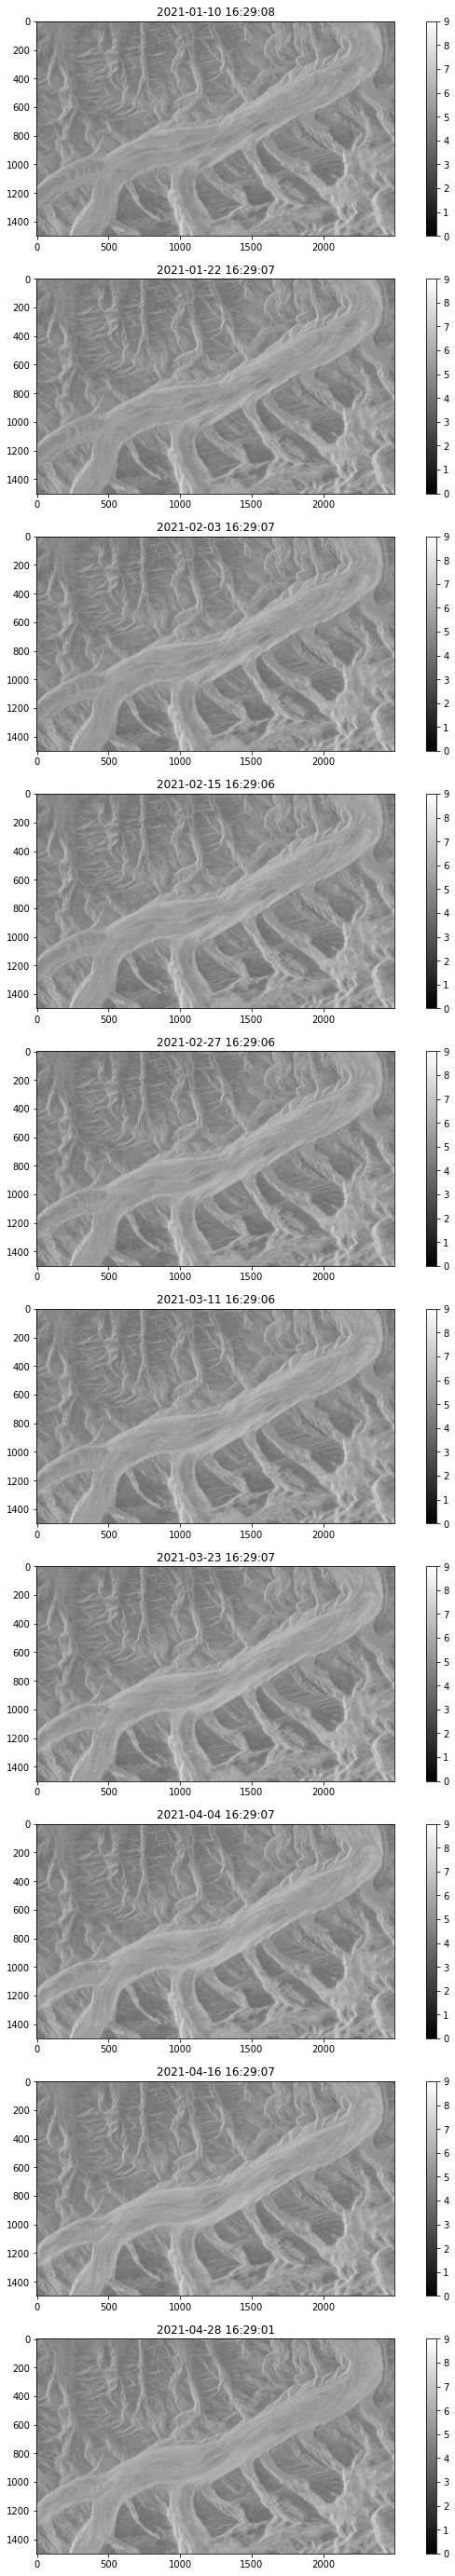

In [9]:
f,ax=plt.subplots(len(file_list),1,figsize=(12,50))
for i,file in enumerate(file_list):
    sar_image = plt.imread(f'{geo_crop_dir}/{file}')
    sar_image_log = np.log(sar_image,where=(sar_image!=0))
    color = ax[i].imshow(sar_image_log[1000:2500,1000:3500],cmap='gray',vmin=0,vmax=9)
    ax[i].set_title(date_list[i])
    f.colorbar(color,ax=ax[i])

## Create and save a gif of the SAR time series stack

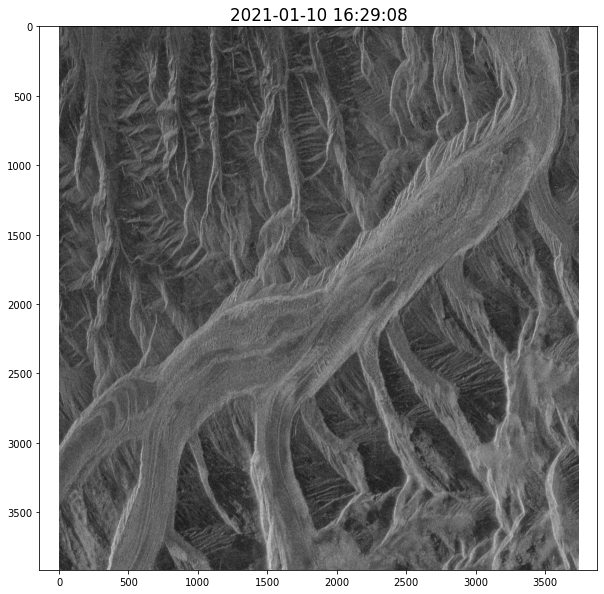

In [10]:
f,ax=plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 14})

sar_image = plt.imread(f'{geo_crop_dir}/{file_list[0]}')
im = ax.imshow(np.log(sar_image,where=(sar_image!=0)),cmap='gray')
ax.set_title(date_list[0])

def update(frame):
    sar_image = plt.imread(f'{geo_crop_dir}/{file_list[frame]}')
    sar_image_log = np.log(sar_image,where=(sar_image!=0))
    im.set_data(sar_image_log[1000:2500,1000:3500])
    ax.set_title(date_list[frame])
    ax.axis('equal')


ani = FuncAnimation(f, update, frames=len(file_list), blit=False, interval=300)

In [11]:
HTML(ani.to_jshtml())

In [12]:
ani.save('muldrow_timeseries_subset.gif', writer='pillow', fps=2)

In [13]:
#TODO: create notebooks to try out different approaches
# whatever way we learn in class
# look at opencv tools, for example: https://docs.opencv.org/master/d7/df3/group__imgproc__motion.html
# speckle offset tracking
# https://mudic.readthedocs.io/en/latest/examples/example.html
# for validation: https://docs.terradue.com/ellip/solutions/notebooks/examples/polar/resources/code/polarstern/04-glacier-velocity.html
# ...

## Take SAR image stack and perform dense optical flow algoritm

In [14]:
# using approach from https://www.geeksforgeeks.org/python-opencv-dense-optical-flow/
# use images instead of video: https://stackoverflow.com/questions/65360091/opencv-optical-flow-using-python
#import cv2
#frame = cv2.imread("path/to/img")
#flow = cv.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
#magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])

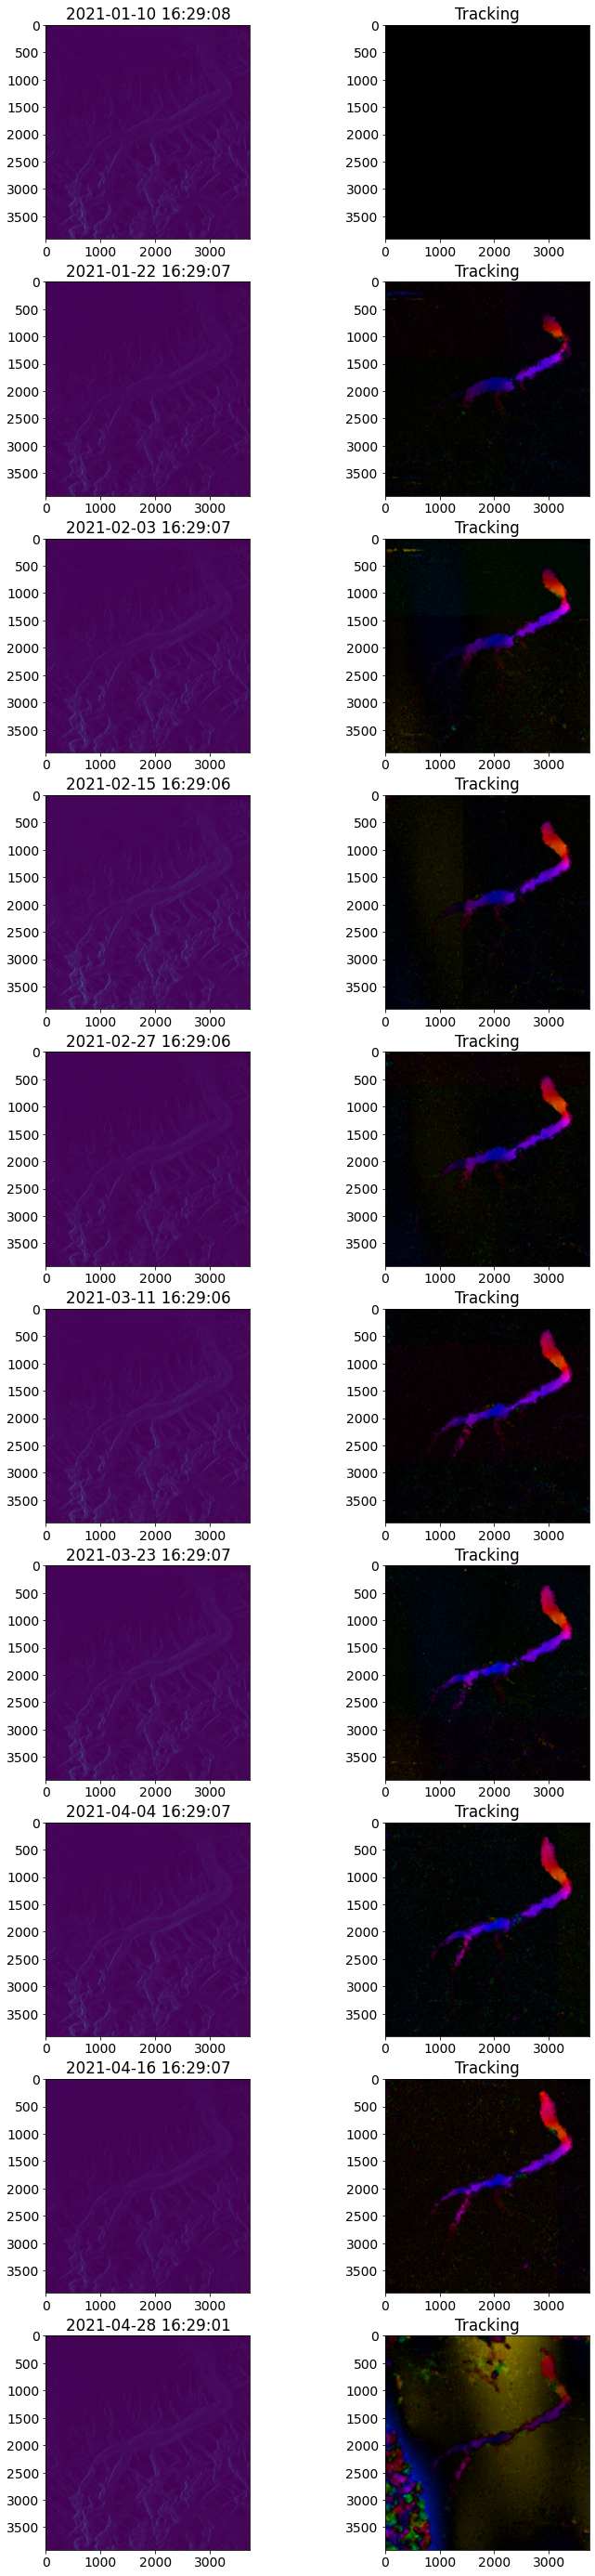

In [53]:
import glob
import cv2 as cv
import numpy as np
from tqdm import notebook
from matplotlib import pyplot as plt

dims = cv.imread(f'{geo_crop_dir}/{file_list[0]}')
first_frame = cv.imread(f'{geo_crop_dir}/{file_list[0]}',cv.IMREAD_UNCHANGED)
#first_frame = plt.imread(f'{geo_crop_dir}/{file_list[0]}')

#prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
prev_gray = first_frame
mask = np.zeros_like(dims)
mask[..., 1] = 255

f,ax=plt.subplots(len(file_list),2,figsize=(12,50))
for i, filename in notebook.tqdm(enumerate(file_list)):  
    frame = cv.imread(f'{geo_crop_dir}/{filename}',cv.IMREAD_UNCHANGED)
    #frame = plt.imread(f'{geo_crop_dir}/{filename}')
    
    ax[i,0].imshow(frame)
    ax[i,0].set_title(date_list[i])
    
    #gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    gray = frame
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, 
                                       None,
                                       0.5, 3, 15, 3, 5, 1.2, 0)
      
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])

    mask[..., 0] = angle * 180 / np.pi / 2
      
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
      
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
      
    ax[i,1].imshow(rgb)
    ax[i,1].set_title('Tracking')
      
    prev_gray = gray

In [44]:
frame

array([[116, 116, 121, ...,   0,   0,   0],
       [135, 123, 119, ...,   0,   0,   0],
       [142, 125, 116, ...,   0,   0,   0],
       ...,
       [131, 143, 149, ...,  83,  71, 100],
       [ 98, 125, 139, ...,  61,  64,  92],
       [ 89, 112, 148, ...,  64,  67,  80]], dtype=uint16)

In [30]:
f,ax=plt.subplots()
frame_log = np.log(frame,where=(frame!=0))
ax.imshow(frame_log)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f40018aed40> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 432x288 with 1 Axes>

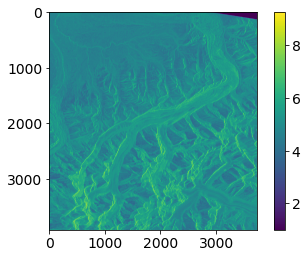

In [47]:
#first_frame = plt.imread(f'{geo_crop_dir}/{filename}')
first_frame = cv.imread(f'{geo_crop_dir}/{filename}',cv.IMREAD_UNCHANGED)
#prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
#prev_gray
#plt.imshow(first_frame)
#plt.colorbar()
plt.imshow(np.log(first_frame,where=first_frame!=0))
plt.colorbar()
#first_frame